<a href="https://colab.research.google.com/github/sidnb13/atomic-gnn-experiments/blob/master/qm9_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimenting with QM9 Hyperparameters and GNN Architecture

The purpose of this notebook is to understand the basics of applying GNNs to the prediction of graph-level attributes on the QM9 molecular dataset.

Installing the prerequisite packages

In [1]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

## Imports and basic model config

In [2]:
from tqdm import tqdm

import torch
import torch.nn.functional as functional

import torch_geometric
import torch_geometric.nn as torch_geo_nn
import torch_geometric.transforms as transforms
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.utils import remove_self_loops, to_networkx

import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

[List of target properties to predict](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9)

Defining some parameters for model and training. Out of 19 targets we choose the 5th one, the HOMO-LUMO gap.

In [47]:
target = 4 # HOMO-LUMO gap
dim = 64
batch_size = 8

## Define transforms

Fully completing a molecular graph presumably allows for message-passing to effectively consider all atoms within one "hop" of each other.

In [48]:
class Complete(object):
    def __call__(self, data):
        # generate fully connected graph
        row = torch.arange(data.num_nodes, dtype=torch.long)
        col = torch.arange(data.num_nodes, dtype=torch.long)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)

        # print('row shape', row.shape)
        # print('col shape', col.shape)

        edge_index = torch.stack([row, col], dim=0)

        print(edge_index)

        edge_attr = None

        if data.edge_attr is not None:
            # indexes where to place edge attributes
            print(data.edge_index[0] * data.num_nodes)
            print(data.edge_index[0] * data.num_nodes + data.edge_index[1])
            # skip the self loop edge created
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]

            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            
            # place new edge attributes on fully connected graph
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr
            
        # print('edge index shape', edge_index.shape)
        # print('edge attrs shape', edge_attr.shape)

        # remove self loop created by above algorithm
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index
        
        return data

Only take the target label.

In [49]:
class TargetTransform(object):
    def __call__(self, data):
        # Returns desired class label
        data.y = data.y[:, target]
        return data

In [50]:
transform_composed_for_nn_conv = transforms.Compose([TargetTransform(), Complete(), transforms.Distance(norm=False)])
transform_composed_default = transforms.Compose([TargetTransform(), transforms.Distance(norm=False)]) # performs better on GRUNet

## Create dataset and feature editing

In [51]:
dataset = QM9('qm9dset', transform=transform_composed_default)

print(dataset)

data = dataset[0]

print('num nodes:', data.num_nodes)
print('num node_features:', data.num_node_features)
print('num edge_features:', data.num_edges)
print('num edge_features:', data.num_edge_features)

print('self loop:', data.has_self_loops())

# labels for all 19 possible classes given
print('label shape', data.y.shape)

print(data.edge_attr)
print(data.x)

QM9(130831)
num nodes: 5
num node_features: 11
num edge_features: 8
num edge_features: 5
self loop: False
label shape torch.Size([1])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919]])
tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


In [52]:
print(dataset.num_features)

11


### Basic data graph visualization

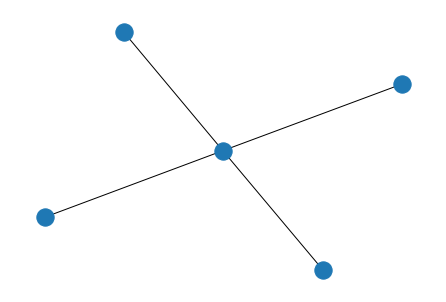

In [53]:
nxg = to_networkx(data, to_undirected=True)
nx.draw(nxg)

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
         4]])
tensor([ 0,  0,  0,  0,  5, 10, 15, 20])
tensor([ 1,  2,  3,  4,  5, 10, 15, 20])


{(0, 1): Text(0.5467652437140748, -0.6053413277181524, '0->1'),
 (0, 2): Text(0.15734213329411229, 0.27186623970485696, '0->2'),
 (0, 3): Text(0.7455421330774623, 0.32641487914988127, '0->3'),
 (0, 4): Text(0.03611159555770904, -0.308963774291044, '0->4'),
 (1, 0): Text(0.5467652437140748, -0.6053413277181524, '1->0'),
 (1, 2): Text(-0.28640002675405196, -0.12279243257699057, '1->2'),
 (1, 3): Text(0.30179997302929806, -0.06824379313196627, '1->3'),
 (1, 4): Text(-0.4076305644904552, -0.7036224465728915, '1->4'),
 (2, 0): Text(0.15734213329411229, 0.27186623970485696, '2->0'),
 (2, 1): Text(-0.28640002675405196, -0.12279243257699057, '2->1'),
 (2, 3): Text(-0.08762313739066441, 0.8089637742910432, '2->3'),
 (2, 4): Text(-0.7970536749104177, 0.1735851208501179, '2->4'),
 (3, 0): Text(0.7455421330774623, 0.32641487914988127, '3->0'),
 (3, 1): Text(0.30179997302929806, -0.06824379313196627, '3->1'),
 (3, 2): Text(-0.08762313739066441, 0.8089637742910432, '3->2'),
 (3, 4): Text(-0.20885367

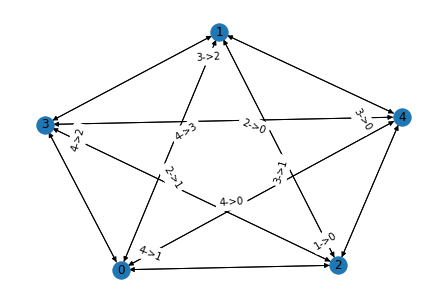

In [54]:
c = Complete().__call__(data) # testing full connection transform

netx_c = to_networkx(c)
pos = nx.spring_layout(netx_c)

edge_labels = {(n1,n2) : str(f'{n1}->{n2}')  for n1, n2 in netx_c.edges}

nx.draw(netx_c, with_labels=True)
nx.draw_networkx_edge_labels(netx_c, pos, edge_labels=edge_labels)

In [55]:
print(c.x)
print(c.edge_attr)

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.00

Perform normalization of data to prevent NaN errors and allow faster convergence

In [56]:
def target_data(dataset):
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std

    # shape is [1,19]
    return mean[:,target].item(), std[:,target].item()


In [68]:
def train_test_val_splits(dataset):
    train_s, test_s, val_s = dataset[:10*batch_size], dataset[10*batch_size:13*batch_size], dataset[13*batch_size:16*batch_size]

    test_load = DataLoader(test_s, batch_size=batch_size, shuffle=False)
    val_load = DataLoader(val_s, batch_size=batch_size, shuffle=False)
    train_load = DataLoader(train_s, batch_size=batch_size, shuffle=True)

    return train_load, test_load, val_load

## Creating model

Different model architectures
**Original example architecture**
- [Helpful resource for NNConv understanding](https://arxiv.org/pdf/1704.01212.pdf)
- Definition of NNconv: $h_i^{l+1}=h_i^l+\text { aggregate }\left(\left\{f_{\Theta}\left(e_{i j}\right) \cdot h_j^l, j \in \mathcal{N}(i)\right\}\right)$
- ${h_i}^l$ represents the $l$th layer's $i$th node
- Intuition: the edge function `nn` for `NNConv` takes in 5 features for 5 edge features
- Set2Set intuition is missing for now but the idea is that each graph has a set of atoms in the organic basis
    - [The formula and paremeters](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.aggr.Set2Set)
- [Resource on readout layers](https://torchdrug.ai/docs/notes/layer.html)

In [69]:
# Defining different layer options to work with

nn_input_dim = dim
nn_output_dim = dim

nn_aggr = 'mean'

# layer_dict = {
#     'GCN': torch_geometric.nn.GCNConv(dataset.num_node_features, dim),
#     'NNConv': torch_geometric.nn.NNConv(nn_input_dim, nn_output_dim, nn, aggr=nn_aggr),
#     'SGConv': torch_geometric.nn.SGConv(dim, dim, add_self_loops=False, bias=True)
# }

# pooling_dict = {
#     'Set2Set': Set2Set(dim, processing_steps=3),
#     'glob_mean': torch.nn.global_mean_pool()
# }

### GRU Net

In [70]:
class GRUNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin0 = torch.nn.Linear(dataset.num_features, dim)

        
        nn = torch.nn.Sequential(
                    torch.nn.Linear(5, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, dim * dim)
                )

        self.conv_layer = NNConv(dim, dim, nn, aggr='mean')
        # self.conv_layer = torch_geometric.nn.GCNConv(dataset.num_node_features, dim)

        # Gated recurrent unit keeps relevant information
        self.gru = torch.nn.GRU(dim, dim)

        self.set2set = Set2Set(dim, processing_steps=3)

        self.lin1 = torch.nn.Linear(2 * dim, dim) # output of set2set is 2dim
        self.lin2 = torch.nn.Linear(dim, 1) # final output prediction

    def forward(self, data):
        out = functional.relu(self.lin0(data.x))
        h = out.unsqueeze(0)

        # apply 3 sequential GRUs
        for _ in range(3):
            m = functional.relu(self.conv_layer(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        # the Set2Set pooling readout layer
        out = self.set2set(out, data.batch)
        # apply ReLU squash
        out = functional.relu(self.lin1(out))
        # final 1D output
        out = self.lin2(out)
        # remove dimensionality
        return out.view(-1)

### Basic GCNConv Net

In [83]:
# a simple network just to see how it compares to PyG GRU example
class BasicGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Linear layer to take in num_features
        self.lin0 = torch.nn.Linear(dataset.num_features, dim)
        
        self.conv_layer_1 = torch_geometric.nn.GCNConv(dim, dim)
        self.conv_layer_2 = torch_geometric.nn.GCNConv(dim, dim)

        self.lin1 = torch.nn.Linear(dim, 1) # final output prediction

    def forward(self, data):
        # print(''.join(['-'] * 30))
        # print(data.batch, data.batch.shape, data.x.shape)

        # print(set(data.batch))
        
        out = self.lin0(data.x)
        out = out.relu()

        out = self.conv_layer_1(out, data.edge_index)
        out = out.relu()
        
        out = self.conv_layer_2(out, data.edge_index)
        out = out.relu()

        # readout layer
        # print('before: ', out.shape)
        out = torch_geometric.nn.global_mean_pool(out, data.batch)
        # print('after: ', out.shape)

        # post readout dimension check
        # print(out.shape)

        # print(''.join(['-'] * 30))
        

        out = self.lin1(out)
        
        return out.view(-1)

In [84]:
model = BasicGCN()
print(model)

BasicGCN(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv_layer_1): GCNConv(64, 64)
  (conv_layer_2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=1, bias=True)
)


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5,
                                                       min_lr=0.00001)

cuda


In [86]:
mean, std = normalize_target_data(dataset)
train_loader, test_loader, val_loader = train_test_val_splits(dataset)

## Training

In [87]:
tol = 1e-3

def train(epoch):
    model.train()
    loss_all = 0

    correct = total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        pred = model(data)
        loss = functional.mse_loss(pred, data.y)
        
        loss.backward()
        
        loss_all += loss.item() * data.num_graphs # batch size

        total += data.num_graphs
        correct += ((pred - data.y).abs() < tol).sum().item()

        optimizer.step()
    return loss_all / len(train_loader.dataset), correct / total

# use this for both val and test set evaluation
def test(loader):
    model.eval()
    error = 0

    correct = total = 0

    for data in loader:
        data = data.to(device)
        pred = model(data)
        error += (pred * std - data.y * std).abs().sum().item()  # MAE

        total += data.num_graphs
        correct += ((pred - data.y).abs() < tol).sum().item()

    return error / len(loader.dataset), correct / total

In [88]:
# test output shapes for debugging
for sample in train_loader:
    data = data.to(device)
    # print(model(data), data.y.shape)
    print(data)

Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 5], y=[1], po

In [89]:
best_val_error = None

train_loss = []
test_err = []
val_err = []

train_acc = []
val_accl = []
test_accl = []


for epoch in range(1, 300):
    lr = scheduler.optimizer.param_groups[0]['lr'] # mess with this later, but keep for now
    loss, acc = train(epoch)
    # break
    val_error, val_acc = test(val_loader)
    scheduler.step(val_error)

    test_error, test_acc = test(test_loader)
    
    if best_val_error is None or val_error <= best_val_error:    
        best_val_error = val_error

    train_loss.append(loss)
    test_err.append(test_error)
    val_err.append(val_error)

    train_acc.append(acc)
    val_accl.append(val_acc)
    test_accl.append(test_acc)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, LR: {lr:7f}, Loss: {loss:.7f}, '
              f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

Epoch: 010, LR: 0.000700, Loss: 3.3376129, Val MAE: 0.7436093, Test MAE: 0.7854305
Epoch: 020, LR: 0.000700, Loss: 2.4408068, Val MAE: 0.7991491, Test MAE: 0.5126153
Epoch: 030, LR: 0.000700, Loss: 2.5755294, Val MAE: 0.7048128, Test MAE: 0.7364720
Epoch: 040, LR: 0.000490, Loss: 2.1680730, Val MAE: 0.8001835, Test MAE: 0.5846203
Epoch: 050, LR: 0.000240, Loss: 2.1407377, Val MAE: 0.7948396, Test MAE: 0.5933602
Epoch: 060, LR: 0.000168, Loss: 2.1215978, Val MAE: 0.8052119, Test MAE: 0.5876175
Epoch: 070, LR: 0.000082, Loss: 2.1138954, Val MAE: 0.8123394, Test MAE: 0.5821433
Epoch: 080, LR: 0.000040, Loss: 2.1086552, Val MAE: 0.8095410, Test MAE: 0.5854045
Epoch: 090, LR: 0.000028, Loss: 2.1058713, Val MAE: 0.8065517, Test MAE: 0.5884447
Epoch: 100, LR: 0.000014, Loss: 2.1035798, Val MAE: 0.8085234, Test MAE: 0.5872124
Epoch: 110, LR: 0.000010, Loss: 2.1029337, Val MAE: 0.8102371, Test MAE: 0.5861124
Epoch: 120, LR: 0.000010, Loss: 2.1030417, Val MAE: 0.8090807, Test MAE: 0.5873468
Epoc


## Metrics

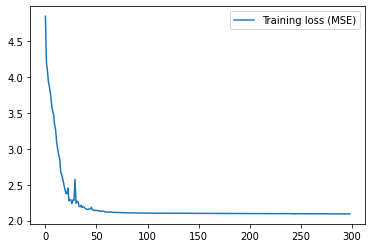

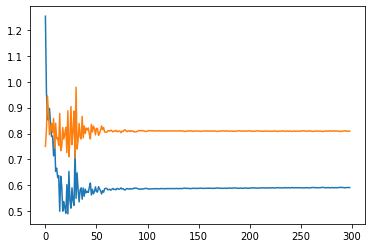

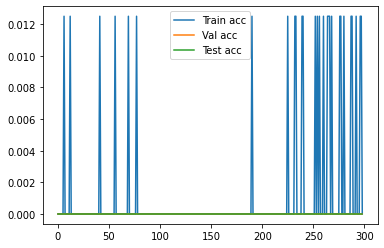

In [90]:
plt.figure(1)

plt.plot(train_loss, label='Training loss (MSE)')

plt.legend()
plt.show()

plt.figure(2)

plt.plot(test_err, label='Test error (MAE)')
plt.plot(val_err, label='Val error (MAE)')

plt.figure(3)

plt.plot(train_acc, label='Train acc')
plt.plot(val_accl, label='Val acc')
plt.plot(test_accl, label='Test acc')

plt.legend()
plt.show()